In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import glob
import cv2
import os
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
from skimage.transform import rotate
from imutils import contours
import imutils
%matplotlib inline

Using TensorFlow backend.


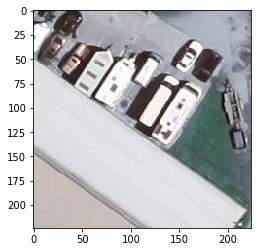

In [5]:
img_o = cv2.imread('Images_for_FCRN/Random/img1/o/img1_1o.jpg')
plt.imshow(img_o,vmin=0,vmax=255)

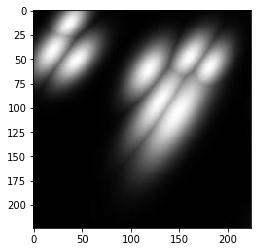

In [7]:
img_gt = cv2.imread('Images_for_FCRN/Random/img1/gt/img1_1gt.jpg')
plt.imshow(img_gt,cmap = 'gray',vmin=0,vmax=255)

In [17]:
rot_o = rotate(img_o, angle=90,mode='reflect')
rot_gt = rotate(img_gt, angle=90,mode = 'reflect')

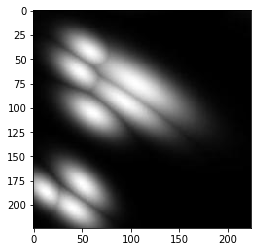

In [18]:
plt.imshow(rot_gt,cmap = 'gray',vmin=0,vmax=255)

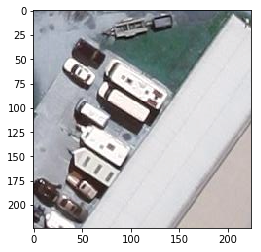

In [19]:
plt.imshow(rot_o,vmin=0,vmax=255)

In [31]:
'''def noisy(image):
    row,col,ch= 224,224,3
    mean = 0
    var = 0.02
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy
'''

In [52]:
def noisy(noise_typ,image):
    image.shape = 224,224,3
    if noise_typ == "gauss":
        row,col,ch= 224,224,3
        mean = 0
        var = 0.02
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = 224,224,3
        s_vs_p = 0.5
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = 224,224,3
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy



In [53]:
rot_o1 = noisy('gauss',rot_o)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


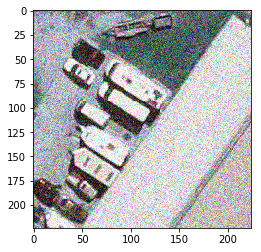

In [54]:
plt.imshow(rot_o1,vmin=0,vmax=255)

In [95]:
imgs_gt =[]
imgs_o = []
count_gt = 0
count_o = 0
for j in range(10):
    #print(j + 1)
    img_cnt = str(j + 1)
    img_path_gt = 'Images_for_FCRN/Random/img' + img_cnt + '/gt'
    img_path_o = 'Images_for_FCRN/Random/img' + img_cnt + '/o'
    for i in range((len(os.listdir(img_path_gt)))):
        cnt = str(i + 1)
        path_gt = img_path_gt + '/img' + img_cnt + '_' + cnt + 'gt.jpg'
        img_gt = cv2.imread(path_gt)
        img_gt = cv2.cvtColor(img_gt,cv2.COLOR_RGB2GRAY)
        if img_gt.shape == (224,224):
            imgs_gt.append(img_gt)
            count_gt = count_gt + 2
            img_gt_rot = rotate(img_gt, angle=90)
            #img_o_noisy = noisy('gauss',img_o)
            imgs_gt.append(img_gt_rot)
        path_o = img_path_o + '/img' + img_cnt + '_' + cnt + 'o.jpg'
        img_o = cv2.imread(path_o,cv2.COLOR_BGR2RGB)
        if img_o.shape == (224,224,3):
            imgs_o.append(img_o/255)
            count_o = count_o + 2
            img_o_rot = rotate(img_o, angle=90)
            img_o_noisy = noisy('gauss',img_o_rot)
            imgs_o.append(img_o_noisy)
        
print(count_gt,' ',count_o)
imgs_gt = np.asarray(imgs_gt)
imgs_gt = imgs_gt.reshape((3477*2,224,224,1))
imgs_o = np.asarray(imgs_o)
print(imgs_gt.shape)
print(imgs_o.shape)


6954   6954
(6954, 224, 224, 1)
(6954, 224, 224, 3)


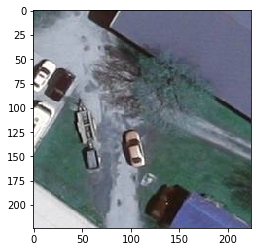

In [96]:
plt.imshow(imgs_o[10],vmin=0,vmax=255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


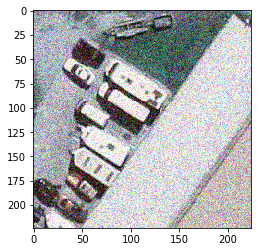

In [98]:
plt.imshow(imgs_o[1])

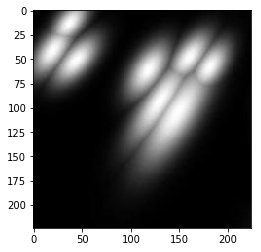

In [99]:
plt.imshow(imgs_gt[0].reshape(224,224),cmap ='gray' )

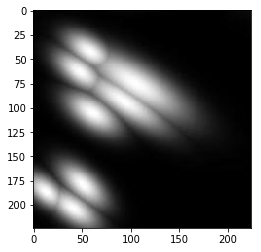

In [100]:
plt.imshow(imgs_gt[1].reshape(224,224),cmap ='gray' )

In [102]:
def ODmodel():
    
    odmodel = VGG16(weights='imagenet', input_shape = (224,224,3),  include_top=False)
    odmodel.layers.pop()
    
    for layer in odmodel.layers:
        layer.trainable = False
    
    
    inputs = odmodel.layers[0].output
    conv53 = odmodel.layers[17].output
    conv5_output = Conv2DTranspose(512,(3,3),padding='same',strides=(2,2),kernel_initializer='he_uniform')(conv53)
    #conv54 = UpSampling2D(size=(2,2))(conv53)
    #conv5_output = Conv2DTranspose(512,(3,3),padding='same',strides=(1,1),kernel_initializer='he_uniform')(conv54)
    
    """X_input = Input(shape=(224,224,3))
    #conv11 = ZeroPadding2D((1, 1))(X_input)
    conv11 = Conv2D(64, (3, 3), strides = (1, 1), activation = 'relu',padding = 'same',trainable = False,name = 'conv2d_21')(X_input)
    #print(conv2d_.get_weights())
    #conv13 = ZeroPadding2D((1, 1))(conv12)
    conv12 = Conv2D(64, (3, 3), strides = (1, 1),activation = 'relu', padding = 'same',trainable = False, name = 'conv12')(conv11)
    conv1_output = MaxPooling2D((2, 2),strides=(2,2), name='max_pool1')(conv12)

    #conv21 = ZeroPadding2D((1, 1))(conv1_output)
    conv21 = Conv2D(128, (3, 3), strides = (1, 1),activation = 'relu', padding = 'same',trainable = False,name = 'conv21')(conv1_output)
    #conv23 = ZeroPadding2D((1, 1))(conv22)
    conv22 = Conv2D(128, (3, 3), strides = (1, 1),activation = 'relu', padding = 'same',trainable = False,name = 'conv22')(conv21)
    conv2_output = MaxPooling2D((2, 2),strides=(2,2), name='max_pool2')(conv22)

    #conv31 = ZeroPadding2D((1, 1))(conv2_output)
    conv31 = Conv2D(256, (3, 3), strides = (1, 1),activation = 'relu',padding = 'same', trainable = False,name = 'conv31')(conv2_output)
    #conv33 = ZeroPadding2D((1, 1))(conv32)
    conv32 = Conv2D(256, (3, 3), strides = (1, 1),activation = 'relu',padding = 'same',trainable = False, name = 'conv32')(conv31)
    #conv35 = ZeroPadding2D((1, 1))(conv34)
    conv33 = Conv2D(256, (3, 3), strides = (1, 1),activation = 'relu',padding = 'same',trainable = False,name = 'conv33')(conv32)
    conv3_output = MaxPooling2D((2, 2),strides=(2,2), name='max_pool3')(conv33)
    
    #conv41 = ZeroPadding2D((1, 1))(conv3_output)
    conv41 = Conv2D(512, (3, 3), strides = (1, 1),activation = 'relu', padding = 'same', trainable = False,name = 'conv41')(conv3_output)
    #conv43 = ZeroPadding2D((1, 1))(conv42)
    conv42 = Conv2D(512, (3, 3), strides = (1, 1),activation = 'relu', padding = 'same', trainable = False,name = 'conv42')(conv41)
    #conv45 = ZeroPadding2D((1, 1))(conv44)
    conv43 = Conv2D(512, (3, 3), strides = (1, 1),activation = 'relu', padding = 'same',trainable = False,name = 'conv43')(conv42)
    conv4_output = MaxPooling2D((2, 2),strides=(2,2), name='max_pool4')(conv43)
    
    #conv51 = ZeroPadding2D((1, 1))(conv4_output)
    conv51 = Conv2D(512, (3, 3), strides = (1, 1),activation = 'relu',padding = 'same',trainable = False,name = 'conv51')(conv4_output)
    #conv53 = ZeroPadding2D((1, 1))(conv52)
    conv52 = Conv2D(512, (3, 3), strides = (1, 1),activation = 'relu', padding = 'same',trainable = False,name = 'conv52')(conv51)
    #conv55 = ZeroPadding2D((1, 1))(conv54)
    conv53 = Conv2D(512, (3, 3), strides = (1, 1),activation = 'relu',padding = 'same',trainable = False,name = 'conv53')(conv52)
    """
    
    conv43 = odmodel.layers[13].output
    D11 = Conv2D(256,(3,3),strides=(1,1),padding='same',kernel_initializer = 'he_uniform',name='convD11')(conv43)
    #drop11 = Dropout(0.2)(D11)
    D12 = BatchNormalization(axis = 3, name = 'bnD11')(D11)
    D13 = Activation('relu')(D12)
    D14 = Conv2D(256,(3,3),strides=(1,1),padding='same',kernel_initializer = 'he_uniform',name='convD12')(D13)
    #drop12 = Dropout(0.2)(D14)
    D15 = BatchNormalization(axis = 3, name = 'bnD12')(D14)
    D1_output = Activation('relu')(D15)
    
    conv33 = odmodel.layers[9].output
    D21 = Conv2D(128,(3,3),strides=(1,1),padding='same',kernel_initializer = 'he_uniform',name='convD21')(conv33)
   # drop21 = Dropout(0.2)(D21)
    D22 = BatchNormalization(axis = 3, name = 'bnD21')(D21)
    D23 = Activation('relu')(D22)
    D24 = Conv2D(128,(3,3),strides=(1,1),padding='same',kernel_initializer = 'he_uniform',name='convD22')(D23)
    #drop22 = Dropout(0.2)(D24)
    D25 = BatchNormalization(axis = 3, name = 'bnD22')(D24)
    D2_output = Activation('relu')(D25)

    conv22 = odmodel.layers[5].output
    D31 = Conv2D(64,(3,3),strides=(1,1),padding='same',kernel_initializer = 'he_uniform',name='convD31')(conv22)
   # drop31 = Dropout(0.2)(D31)
    D32 = BatchNormalization(axis = 3, name = 'bnD31')(D31)
    D33 = Activation('relu')(D32)
    D34 = Conv2D(64,(3,3),strides=(1,1),padding='same',kernel_initializer = 'he_uniform',name='convD32')(D33)
    #drop32 = Dropout(0.2)(D34)
    D35 = BatchNormalization(axis = 3, name = 'bnD32')(D34)
    D3_output = Activation('relu')(D35)
    
    decon11 = Concatenate()([D1_output,conv5_output])
    decon12 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv11')(decon11)
    decon13 = BatchNormalization(axis = 3, name = 'bnde11')(decon12)
    decon14 = Activation('relu')(decon13)
    decon15 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv12')(decon14)
    decon16 = BatchNormalization(axis = 3, name = 'bnde12')(decon15)
    decon17 = Activation('relu')(decon16)
    decon1_output = Conv2DTranspose(256,(3,3),padding='same',strides=(2,2),kernel_initializer='he_uniform')(decon17)
    #decon18 = UpSampling2D(size=(2,2))(decon17)
    #decon1_output = Conv2DTranspose(256,(3,3),padding='same',strides=(1,1),kernel_initializer='he_uniform')(decon18)
    
    decon21 = Concatenate()([D2_output,decon1_output])
    decon22 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv21')(decon21)
    decon23 = BatchNormalization(axis = 3, name = 'bnde21')(decon22)
    decon24 = Activation('relu')(decon23)
    decon25 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv22')(decon24)
    decon26 = BatchNormalization(axis = 3, name = 'bnde22')(decon25)
    decon27 = Activation('relu')(decon26)
    decon2_output =Conv2DTranspose(256,(3,3),padding='same',strides=(2,2),kernel_initializer='he_uniform')(decon27)
    #decon28 = UpSampling2D(size=(2,2))(decon27)
    #decon2_output = Conv2DTranspose(256,(3,3),padding='same',strides=(1,1),kernel_initializer='he_uniform')(decon28)
    
    decon31 = Concatenate()([D3_output,decon2_output])
    decon32 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv31')(decon31)
    decon33 = BatchNormalization(axis = 3, name = 'bnde31')(decon32)
    decon34 = Activation('relu')(decon33)
    decon35 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv32')(decon34)
    decon36 = BatchNormalization(axis = 3, name = 'bnde32')(decon35)
    decon37 = Activation('relu')(decon36)
    decon3_output = Conv2DTranspose(256,(3,3),padding='same',strides=(2,2),kernel_initializer='he_uniform')(decon37)
    #decon38 = UpSampling2D(size=(2,2))(decon37)
    #decon3_output = Conv2DTranspose(256,(3,3),padding='same',strides=(1,1),kernel_initializer='he_uniform')(decon38)
    
    decon41 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv41')(decon3_output)
    decon42 = BatchNormalization(axis = 3, name = 'bnde41')(decon41)
    decon43 = Activation('relu')(decon42)
    decon44 = Conv2D(256,(3,3),strides=(1,1),padding = 'same',kernel_initializer = 'he_uniform',name='deconv42')(decon43)
    decon45 = BatchNormalization(axis = 3, name = 'bnde42')(decon44)
    decon4_output = Activation('relu')(decon45)
    
    decon5_output = Conv2D(1,(1,1),strides=(1,1),activation = 'linear',padding = 'same',kernel_initializer = 'he_uniform',name='decon51')(decon4_output)
    #decon52 = Flatten()(decon51)
    #decon5_output = Lambda(lambda x: x*255)(decon51)
    
    layers = decon5_output
    
    model = Model(inputs,layers,name = "ODModel")
    #print(model.get_weights())
    #model.load_weights(weights_path,by_name=True)
    #print(model.get_weights())
    
    print(model.summary())
    return model

In [101]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False)

datagen.fit(imgs_o)

In [103]:
class LossHistory(Callback):
    def on_train_begin(self,logs={}):
        self.losses=[]
        self.lr = []
        
    def on_epoch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))

In [104]:
def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.1
    lrate = initial_lrate * exp(-k*epoch)
    return lrate

lrate = LearningRateScheduler(exp_decay)


In [105]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

In [106]:
loss_history = LossHistory()
#callbacks_list = [loss_history,lrate,plot]
callbacks_list = [loss_history,plot]

In [107]:
odmodel = ODmodel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [108]:
lr_rate = 0.01
decay_rate = lr_rate/200;

my_optimizer = RMSprop(lr = 0.01,epsilon=None,decay = decay_rate)
odmodel.compile(optimizer=my_optimizer, loss='mean_squared_error',metrics = ["accuracy"])

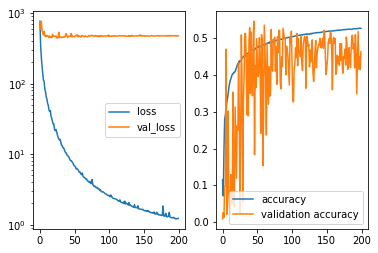

In [109]:
odmodel.fit(imgs_o,imgs_gt,validation_split = 0.2,epochs=200,callbacks=callbacks_list,batch_size=8)

In [110]:
odmodel.save('draft3.h5')

In [ ]:
predictor()